In [1]:
import pandas as pd
import numpy as np
import math
from collections import defaultdict
import ts_code.nsfg as nsfg
import ts_code.thinkstats2 as thinkstats2
import ts_code.thinkplot as thinkplot
import ts_code.brfss as brfss
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = brfss.ReadBrfss(nrows=None)
sample = thinkstats2.SampleRows(df, 5000)

In [3]:
heights, weights = sample.htm3, sample.wtkg2

## Chapter 7 - Relationships between variables

Two variables are related if knowing one gives you information about the other. For example, height and weight are related; people who are taller tend to be heavier.

Simplest way to check for a relationship is to create a **scatter plot**. Sometimes our data may come to use rounded or in some other way smoothed out, this can result in the points on the scatter plot being packed into columns.

We can't get that information back, but we can minimize the effect on the
scatter plot by **jittering** the data, which means adding random noise to
reverse the effect of rounding off.

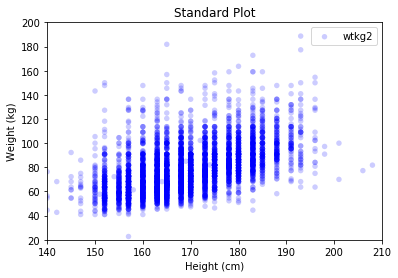

In [4]:
thinkplot.Scatter(heights, weights)
thinkplot.Show(xlabel='Height (cm)', ylabel='Weight (kg)', title='Standard Plot',
               axis=[140, 210, 20, 200])

In [6]:
#Here's the implementation of Jitter:
def Jitter(values, jitter=0.5):
    n = len(values)
    return np.random.uniform(-jitter, +jitter, n) + values

heights = thinkstats2.Jitter(heights, 1.3)
weights = thinkstats2.Jitter(weights, 0.5)

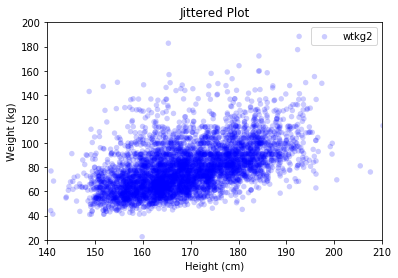

In [7]:
thinkplot.Scatter(heights, weights)
thinkplot.Show(xlabel='Height (cm)', ylabel='Weight (kg)',  title='Jittered Plot',
               axis=[140, 210, 20, 200])

Jittering reduces the visual effect of rounding and makes the shape of the relationship clearer. But in general you should only jitter data for purposes of visualization and avoid using jittered data for analysis.

Even with jittering, this is not the best way to represent the data. 

There are many overlapping points, which hides data in the dense parts of the figure and gives disproportionate emphasis to outliers. This effect is called
**saturation** and it can be solved using the *alpha* paremeter to make points partly transparent.

Overlapping data points look darker, so darkness is proportional to density.

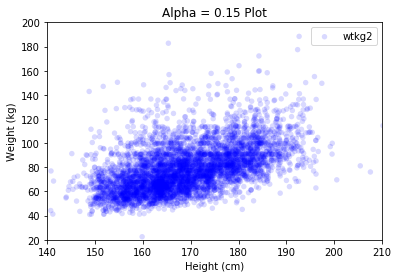

In [8]:
thinkplot.Scatter(heights, weights, alpha=0.15)
thinkplot.Show(xlabel='Height (cm)', ylabel='Weight (kg)',  title='Alpha = 0.15 Plot',
               axis=[140, 210, 20, 200])

Using transparency works well for moderate-sized datasets; to handle larger datasets, another option is a **hexbin plot**, which divides the graph into hexagonal bins and colors each bin according to how many data points fall in it.

An advantage of a hexbin is that it shows the shape of the relationship well, and it is efficient for large datasets, both in time and in the size of the file it creates. A drawback is that it makes the outliers invisible.

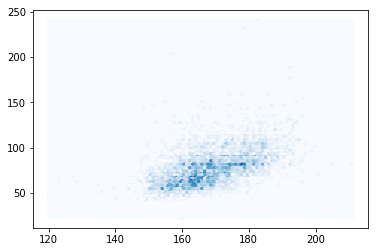

In [9]:
thinkplot.HexBin(heights, weights)

Another option for visualizing the relationship is to bin one variable and plot the percentiles of the other.

In [10]:
#NumPy and pandas provide functions for binning data:

#dropna drops rows with nan in any of the listed columns.
df = df.dropna(subset=['htm3','wtkg2'])
#arange makes a NumPy array of bins from 135 to, 
#but not including, 210, in increments of 5.
bins = np.arange(135, 210, 5)
#digitize computes the index of the bin that contains each value in df.htm3.
#The result is a NumPy array of integer indices.
indices = np.digitize(df.htm3, bins)
groups = df.groupby(indices)

In [11]:
#print number of rows in each group
for i, group in groups:
    print(i, len(group))

0 305
1 228
2 477
3 2162
4 18759
5 45761
6 70610
7 72138
8 61725
9 49938
10 43555
11 20077
12 7784
13 1777
14 405
15 131


In [12]:
#compute the mean height and the CDF of weight:

heights = [group.htm3.mean() for i, group in groups]
cdfs = [thinkstats2.Cdf(group.wtkg2) for i, group in groups]

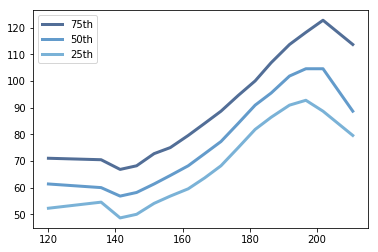

In [13]:
#plot percentiles of weight versus height:
for percent in [75, 50, 25]:
    weights = [cdf.Percentile(percent) for cdf in cdfs]
    label = '%dth' % percent
    thinkplot.Plot(heights, weights, label=label)
    plt.legend()

Between 140 and 200 cm the relationship between these variables is roughly linear. This range includes more than 99% of the data, so we don't have to worry too much about the extremes.

A **correlation** is a statistic intended to quantify the strength of the relationship between two variables.

A challenge in measuring correlation is that the variables we want to compare
are often not expressed in the same units. There are two common solutions to this problem;

1. Transform each value to a **standard scores**, which is the number of standard deviations from the mean. This transform leads to the "Pearson product-moment correlation coefficient."

2. Transform each value to its **rank**, which is its index in the sorted list of values. This transform leads to the "Spearman rank correlation coefficient."

If $X$ is a series of $n$ values, $x_{i}$, we can convert to standard scores by subtracting the mean and dividing by the standard deviation;

$$z_{i}=\frac{(x_{i} - \mu)}{\sigma}$$

The numerator is a *deviation*: the distance from the mean. 

Dividing by $\sigma$, *standardizes* the deviation, so the values of $Z$ are dimensionless and their distribution has mean 0 and variance 1.

If $X$ is normally distributed, so is $Z$. If $X$ is skewed or has outliers,
so does $Z$; in those cases, it is more **robust** to use **percentile ranks**.

If we compute a new variable, $R$, so that $r_{i}$ is the rank of $x_{i}$, the distribution of $R$ is uniform from 1 to $n$, regardless of the distribution of $X$.

**Covariance** is a measure of the tendency of two variables to vary together.

If we have two series, $X$ and $Y$, their deviations are;

$$dx_{i} = x_{i} - \bar{x} \text{,  } dy_{i}=y_{i}-\bar{y}$$

where $\bar{x}$ is the sample mean of $X$ and $\bar{y}$ is the sample mean of $Y$. If $X$ and $Y$ vary together their deviations tend to have the same sign.

If we multiply them together, the product is *positive* when the deviations have
the *same sign* and *negative* when they have the *opposite sign*. 

So adding up the products gives a measure of the tendency to vary together.

$$Cov(X,Y) = \frac{1}{n} \sum dx_{i}dy_{i}$$

where $n$ is the length of the two series (they have to be the same length).

You can that **Cov** is the dot product of the deviations, divided by their length. The covariance is maximized if the two vectors are identical, 0 if they are orthogonal(statistically independent), and negative if they point in opposite directions. 

You can use np.dot to compute the covariance efficiently.

Covariance can be useful, but it is normally not reported because its messy units make it hard to interpert. The units are the product of the units of $X$ and $Y$. So for the covariance of weight and height, we would have "kilogram-centimeters".

One solution to this problem is to divide the deviations by the standard deviation, which yields standard scores, and compute the product of standard scores:

$$p_{i} = \frac{(x_{i}-\bar{x})}{\sigma_{x}} \cdot \frac{(y_{i}-\bar{y})}{\sigma_{y}}$$

The mean is;

$$p=\frac{1}{n} \sum p_{i}$$

We can also factor out the standard deviations and rewrite $p$ as;

$$p = \frac{Cov(X,Y)}{\sigma_{x}\sigma_{y}}$$

This value is called **Pearson's correlation** after Karl Pearson, an influential early statistician. It is easy to compute and easy to interpret because it is dimensionless.

Pearson's correlation is always between -1 and +1 (including both). 

+ If $p$ is positive, we say that the correlation is positive, which means that when one variable is high, the other tends to be high. 

+ If $p$ is negative, the correlation is negative, so when one variable is high, the other is low.

The magnitude of $p$ indicates the strength of the correlation. If $p$ is 1 or -1, the variables are **perfectly correlated**, which means that if you know one, you can make a perfect prediction about the other.

**Examples of datasets with a range of correlations**

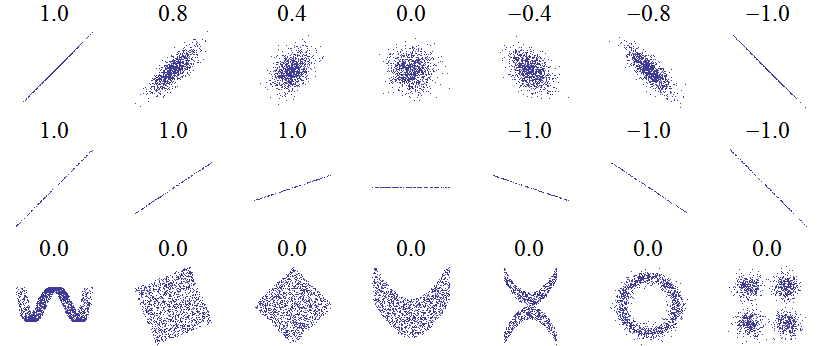

When Pearson's correlation is near 0, it could be because there is no relationship between the variables, but this value only measures *linear* relationships. 

If there's a nonlinear relationship, $p$ understates its strength.

Pearson's correlation works well if the relationship between variables is linear
and if the variables are roughly normal. But it is not robust in the presence
of outliers.

You should always look at a scatter plot of your data before blindly computing a correlation coefficient.

**Spearman's rank correlation** is an alternative that mitigates the effect of outliers and skewed distributions. 

To compute Spearman's correlation, we have to compute the **rank** of each value, which is its index in the sorted sample.

*ie:* in [1,2,5,7]; the rank of 5 is 3.

The pandas series object provides a method *.rank()*, which computes the rank for each values and returns a series.

If the relationship is nonlinear, Pearson's correlation tends to underestimate the strength of the relationship.

Pearson's correlation can be affected (in either direction) if one of the distributions is skewed or contains outliers. Spearman's rank correlation is more robust.

If variables A and B are **correlated**, there are three possible explanations:

1. A causes B
2. B causes A, 
3. some other set of factors causes both A and B.

These explanations are called "causal relationships".

Correlation alone does not distinguish between these explanations, so it
does not tell you which ones are true. 

**"Correlation does not imply causation."**

How can we provide evidence of causation? It's pretty difficult;

1. Use time. If A comes before B, then A can cause B but not the other way around (at least according to our common understanding of causation). The order of events can help us infer the direction of causation, but it does not preclude the possibility that something else causes both A and B.

2. Use randomness. If you divide a large sample into two groups at random and compute the means of almost any variable, you expect the difference to be small. If the groups are nearly identical in all variables but one, you can eliminate spurious relationships. This works even if you don't know what the relevant variables are, but it works even better if you do, because you can check that the groups are identical.

These are the basis and motivation for **randomized controlled trials**, in
which subjects are assigned randomly to two (or more) groups: a **treatment group** that receives some kind of intervention, and a **control group** that receives no intervention.

A randomized controlled trial is the most reliable way to demonstrate a causal relationship, and the foundation of science-based medicine.

Unfortunately, controlled trials are only possible in the laboratory sciences,
medicine, and a few other disciplines. In the social sciences, controlled experiments are rare, usually because they are impossible or unethical.

An alternative is to look for a **natural experiment**, where different "treatments" are applied to groups that are otherwise similar. 

This is an empirical study in which individuals (or clusters of individuals) exposed to the experimental and control conditions are determined by nature or by other factors outside the control of the investigators, but the process  governing the exposures arguably resembles random assignment.

One danger of natural experiments is that the groups might differ in ways that are not apparent.

In some cases it is possible to infer causal relationships using **regression
analysis**.

### Exercises

**Exercise 7.1** Using data from the NSFG, make a scatter plot of birth weight versus mother's age. 

Plot percentiles of birth weight versus mother's age. 

Compute Pearson's and Spearman's correlations. 

How would you characterize the relationship between these variables?

In [16]:
preg = nsfg.ReadFemPreg()
resp = nsfg.ReadFemResp()

In [15]:
preg.head()

,caseid,pregordr,howpreg_n,howpreg_p,moscurrp,nowprgdk,pregend1,pregend2,nbrnaliv,multbrth,...,laborfor_i,religion_i,metro_i,basewgt,adj_mod_basewgt,finalwgt,secu_p,sest,cmintvw,totalwgt_lb
0,1,1,NaN,NaN,NaN,NaN,6.0,NaN,1.0,NaN,...,0,0,0,3410.389399,3869.349602,6448.271112,2,9,NaN,8.8125
1,1,2,NaN,NaN,NaN,NaN,6.0,NaN,1.0,NaN,...,0,0,0,3410.389399,3869.349602,6448.271112,2,9,NaN,7.8750
2,2,1,NaN,NaN,NaN,NaN,5.0,NaN,3.0,5.0,...,0,0,0,7226.301740,8567.549110,12999.542264,2,12,NaN,9.1250
3,2,2,NaN,NaN,NaN,NaN,6.0,NaN,1.0,NaN,...,0,0,0,7226.301740,8567.549110,12999.542264,2,12,NaN,7.0000
4,2,3,NaN,NaN,NaN,NaN,6.0,NaN,1.0,NaN,...,0,0,0,7226.301740,8567.549110,12999.542264,2,12,NaN,6.1875


In [17]:
resp.head()

,caseid,rscrinf,rdormres,rostscrn,rscreenhisp,rscreenrace,age_a,age_r,cmbirth,agescrn,...,pubassis_i,basewgt,adj_mod_basewgt,finalwgt,secu_r,sest,cmintvw,cmlstyr,screentime,intvlngth
0,2298,1,5,5,1,5.0,27,27,902,27,...,0,3247.916977,5123.759559,5556.717241,2,18,1234,1222,18:26:36,110.492667
1,5012,1,5,1,5,5.0,42,42,718,42,...,0,2335.279149,2846.799490,4744.191350,2,18,1233,1221,16:30:59,64.294000
2,11586,1,5,1,5,5.0,43,43,708,43,...,0,2335.279149,2846.799490,4744.191350,2,18,1234,1222,18:19:09,75.149167
3,6794,5,5,4,1,5.0,15,15,1042,15,...,0,3783.152221,5071.464231,5923.977368,2,18,1234,1222,15:54:43,28.642833
4,616,1,5,4,1,5.0,20,20,991,20,...,0,5341.329968,6437.335772,7229.128072,2,18,1233,1221,14:19:44,69.502667


In [64]:
live = preg[preg.outcome == 1]

In [83]:
age_birthwgt = pd.concat([live['agepreg'], live['totalwgt_lb']], axis=1)

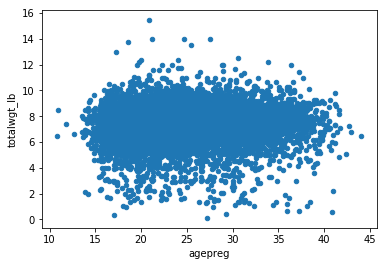

In [84]:
age_birthwgt.plot.scatter('agepreg', 'totalwgt_lb')

In [89]:
age_birthwgt['agepreg_J'] = Jitter(age_birthwgt['agepreg'], 0.5)
#jitter by 0.5, with the idea that that was half a year of rounding

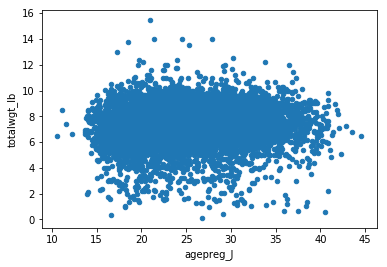

In [90]:
age_birthwgt.plot.scatter('agepreg_J', 'totalwgt_lb')

In [91]:
age_birthwgt.dropna(inplace=True)

In [101]:
#arange makes a NumPy array of bins from 135 to, 
#but not including, 210, in increments of 5.
bins = np.arange(15, 50, 5)
#digitize computes the index of the bin that contains each value in.
#The result is a NumPy array of integer indices.
indices = np.digitize(age_birthwgt.agepreg, bins)
groups = age_birthwgt.groupby(indices)

In [102]:
#compute the mean height and the CDF of weight:
ages = [group.agepreg.mean() for i, group in groups]
cdfs = [thinkstats2.Cdf(group.totalwgt_lb) for i, group in groups]

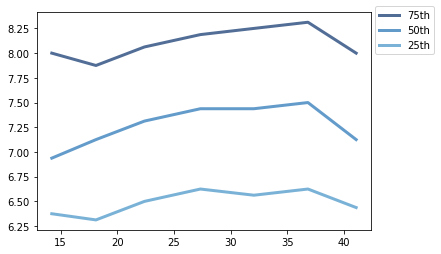

In [103]:
for percent in [75, 50, 25]:
    weights = [cdf.Percentile(percent) for cdf in cdfs]
    label = '%dth' % percent
    thinkplot.Plot(ages, weights, label=label)
    plt.legend(loc = 'upper center', bbox_to_anchor=(1.1, 1.05), ncol=1)

In [59]:
def Pearsons(X, Y):
    cov = np.dot(X-np.mean(X), Y-np.mean(Y)) / len(X)
    p = cov / (np.std(X) * np.std(Y))
    return p

In [60]:
def Spearman(X, Y):
    xranks = X.rank()
    yranks = Y.rank()
    return Pearsons(xranks, yranks)

In [99]:
p = Pearsons(age_birthwgt['agepreg'], age_birthwgt['totalwgt_lb'])
sp = Spearman(age_birthwgt['agepreg'], age_birthwgt['totalwgt_lb'])

In [100]:
print('Pearson: %.02f, Spearman: %.02f' % (p, sp))

Pearson: 0.07, Spearman: 0.09


>There appears to be little to no relationship between the age of the mother and birth weight of the baby. The scatter plot shows a pretty uniform distribution, even after applying jitter. The plot of age vs birth weight percentile, shows an increase from 15 to about 25, then the effect is very weak. The final indicator that there isn't much of a relationship, is that both the Pearson's and Spearman's coefficients are very close to 0.

### Glossary

**scatter plot:** A visualization of the relationship between two variables, showing one point for each row of data.

**jitter:** Random noise added to data for purposes of visualization.

**saturation:** Loss of information when multiple points are plotted on top of each other.

**correlation:** A statistic that measures the strength of the relationship between two variables.

**standardize:** To transform a set of values so that their mean is 0 and their variance is 1.

**standard score:** A value that has been standardized so that it is expressed in standard deviations from the mean.

**covariance:** A measure of the tendency of two variables to vary together.

**rank:** The index where an element appears in a sorted list.

**randomized controlled trial:** An experimental design in which subjects are divided into groups at random, and dierent groups are given different treatments.

**treatment group:** A group in a controlled trial that receives some kind of intervention.

**control group:** A group in a controlled trial that receives no treatment, or a treatment whose effect is known.

**natural experiment:** An experimental design that takes advantage of a natural division of subjects into groups in ways that are at least approximately random.